In [1]:
import sys
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, ARIMA, ARMA, arma_order_select_ic
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

%matplotlib inline

In [2]:
# 设置图片参数
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['figure.figsize'] = (15, 8)  # 图片大小
plt.rcParams['savefig.dpi'] = 300  # 图片像素
# plt.rcParams['figure.dpi'] = 300  # 分辨率

## 1 数据预处理

In [3]:
# 加载数据
data_path = "../data/engine_oil.txt"
df = pd.read_csv(data_path, sep='\t', encoding='utf-8')

In [4]:
df = df.rename(columns={'物料编码': 'part_id', '物料描述': 'part_name', 
                        '订货数': 'order_num', '缺件数': 'out_of_stock_num', 
                        '受理数': 'delivery_num', '审核日期': 'date', '审核时间': 'time'})

# 将`part_id`的数据类型设为字符串，方便后面进行重采样 
df['part_id'] = df['part_id'].astype('str')

# 重置索引
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df.set_index('date', inplace=True)

In [5]:
# 去除2016年10月份的数据
df = df[3:]

In [6]:
# 重采样
df_day = df.resample('D').sum()

In [7]:
df_day['weekday'] = df_day.index.weekday

In [8]:
df_day_wed = df_day[df_day['weekday'] == 2]
train_wed = df_day_wed[:-12]
test_wed = df_day_wed[-12:]

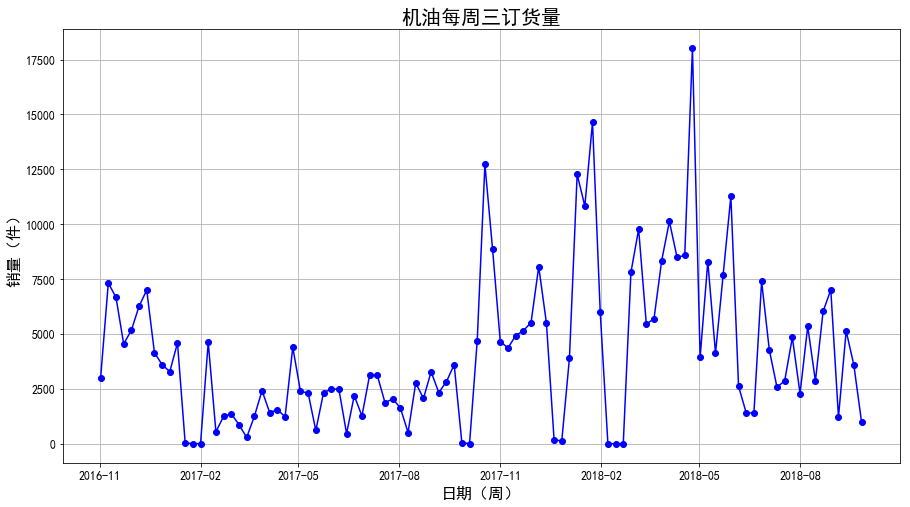

In [9]:
fig, ax = plt.subplots()
ax.plot(df_day_wed.index, df_day_wed.order_num.values, 'bo-')
ax.set_xlabel('日期（周）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('机油每周三订货量', fontsize=20)
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

## 2 时间序列检验

### 2.1 自相关图和偏自相关图

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


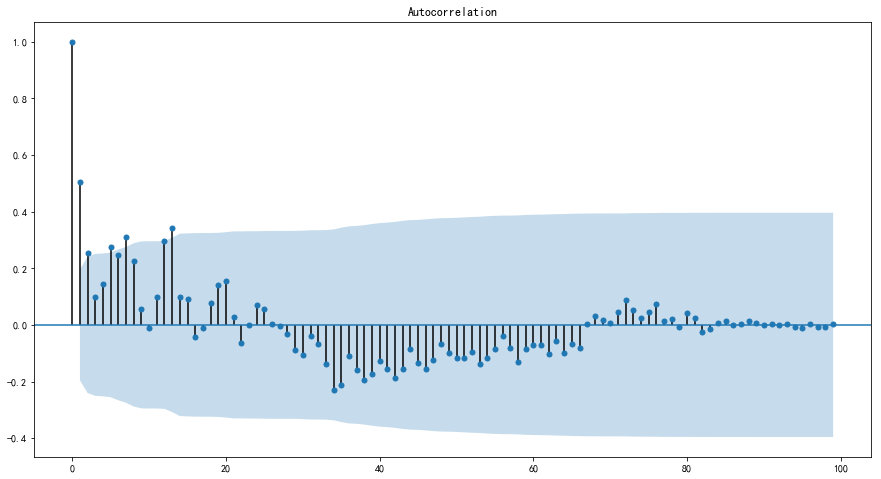

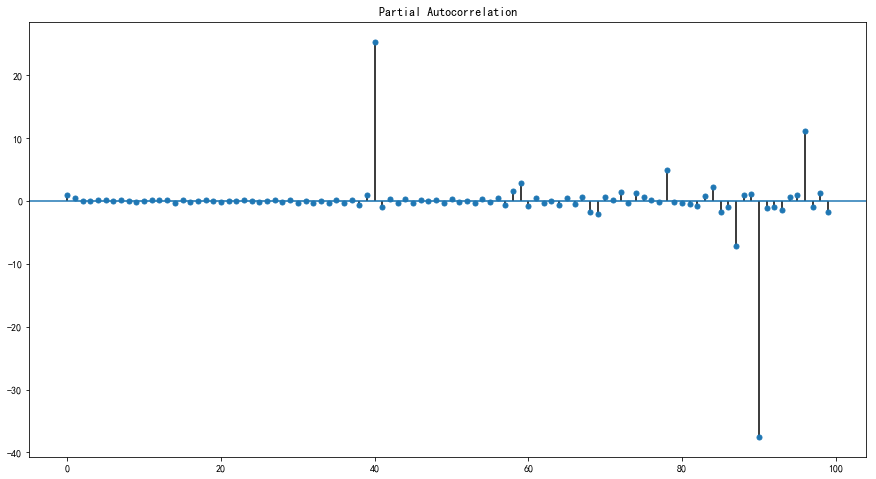

In [10]:
# 周的自相关图
plot_acf(df_day_wed.order_num.values).show()
plot_pacf(df_day_wed.order_num.values).show()

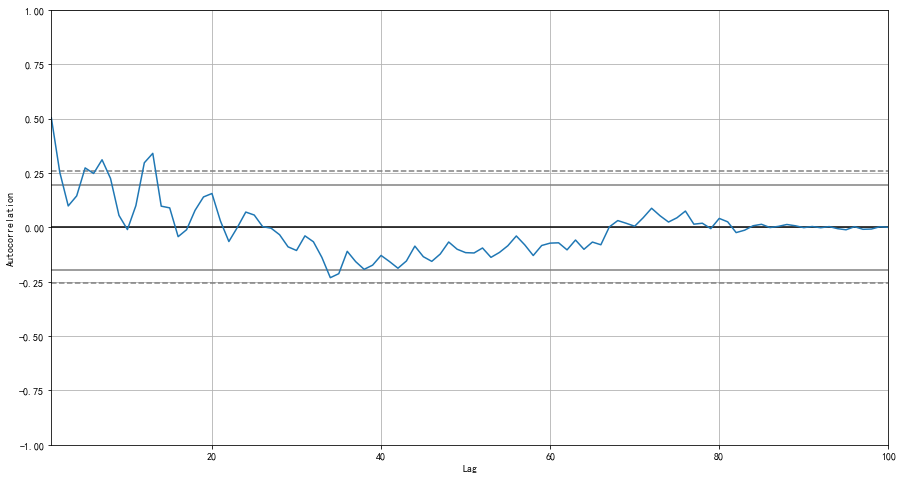

In [11]:
autocorrelation_plot(df_day_wed.order_num.values)
plt.show()

### 2.2 单位根检验

In [12]:
# 周三的单位根检验
adf_result = adfuller(df_day_wed.order_num.values)
output = pd.DataFrame(index=["Test Statistic Value", "p-value", "Lags Used", "Number of Observations Used", "Critical Value (1%)", "Critical Value (5%)", "Critical Value (10%)"], columns=['value'])
output['value']['Test Statistic Value'] = adf_result[0]
output['value']['p-value'] = adf_result[1]
output['value']['Lags Used'] = adf_result[2]
output['value']['Number of Observations Used'] = adf_result[3]
output['value']['Critical Value (1%)'] = adf_result[4]['1%']
output['value']['Critical Value (5%)'] = adf_result[4]['5%']
output['value']['Critical Value (10%)'] = adf_result[4]['10%']
print("周三序列的单位根检验结果为：")
print(output)

周三序列的单位根检验结果为：
                                   value
Test Statistic Value            -5.59734
p-value                      1.28806e-06
Lags Used                              0
Number of Observations Used           99
Critical Value (1%)              -3.4982
Critical Value (5%)             -2.89121
Critical Value (10%)             -2.5826


### 2.3 纯随机性检验

In [13]:
# 月的纯随机性检验
print("序列的纯随机性检验结果为：", end='')
print(acorr_ljungbox(df_day_wed.order_num.values, lags=1)[1][0])

序列的纯随机性检验结果为：3.124722750509612e-07


## 3 模型拟合

### 3.1 指数平滑

In [14]:
train, test = train_wed.order_num.values, test_wed.order_num.values

In [33]:
model = SimpleExpSmoothing(train)
model_fit = model.fit(smoothing_level=1, optimized=False)
preds = model_fit.forecast(12)

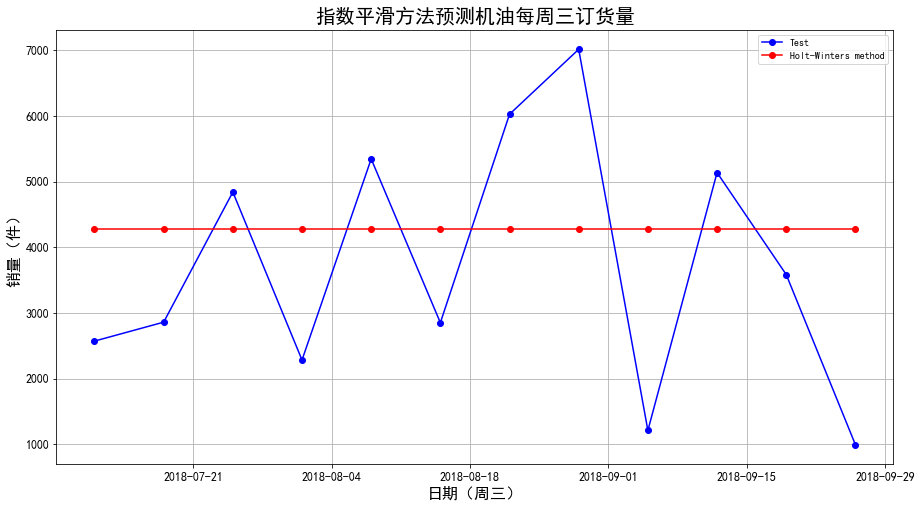

In [34]:
fig, ax = plt.subplots()
# ax.plot(train_month.index, train_month.order_num.values, 'go-', label='Train')
ax.plot(test_wed.index,test, 'bo-', label='Test')
ax.plot(test_wed.index, preds, 'ro-', label='Holt-Winters method')
ax.set_xlabel('日期（周三）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('指数平滑方法预测机油每周三订货量', fontsize=20)
ax.legend(loc='best')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [17]:
rmse = sqrt(mean_squared_error(test, preds))
print("The RMSE of 'Holt-Winters method' is:", rmse)

The RMSE of 'Holt-Winters method' is: 1920.7071614382032


### 3.2 Holt-Winters method

In [49]:
train, test = train_wed.order_num.values, test_wed.order_num.values

In [50]:
model = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='add')
model_fit = model.fit()
preds = model_fit.forecast(12)

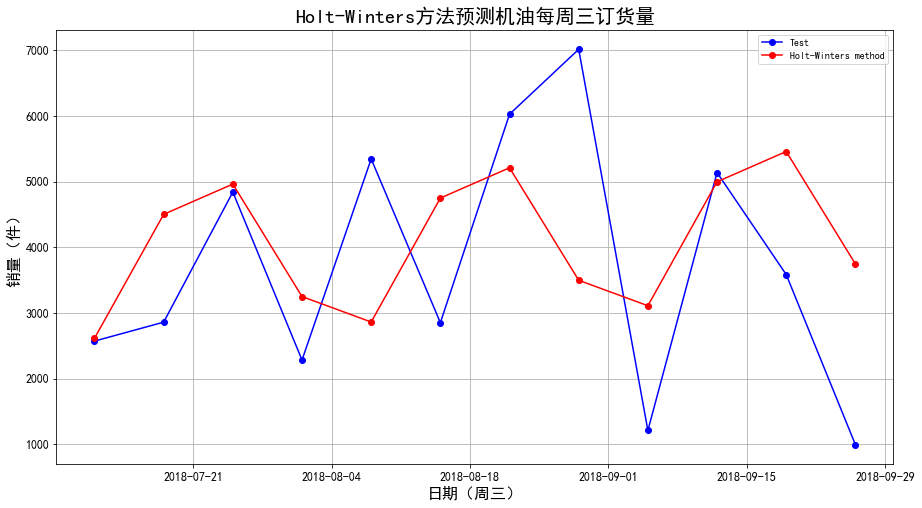

In [51]:
fig, ax = plt.subplots()
# ax.plot(train_month.index, train_month.order_num.values, 'go-', label='Train')
ax.plot(test_wed.index,test, 'bo-', label='Test')
ax.plot(test_wed.index, preds - 1100, 'ro-', label='Holt-Winters method')
ax.set_xlabel('日期（周三）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('Holt-Winters方法预测机油每周三订货量', fontsize=20)
ax.legend(loc='best')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [52]:
rmse = sqrt(mean_squared_error(test, preds - 1100))
print("The RMSE of 'Holt-Winters method' is:", rmse)

The RMSE of 'Holt-Winters method' is: 1850.7083140590387


### 3.3 ARIMA

In [22]:
train, test = train_wed.order_num.values, test_wed.order_num.values

In [23]:
pmax = len(df_day_wed) // 10
qmax = len(df_day_wed) // 10 

bic_matrix = [] 
for p in range(pmax + 1):
    temp = []
    for q in range(qmax + 1):
        try: 
            temp.append(ARIMA(train, (p, 0, q)).fit().aic)
        except:
            temp.append(None)
    bic_matrix.append(temp)

bic_matrix = pd.DataFrame(bic_matrix).astype('float').dropna(axis=1)
p, q = bic_matrix.stack().idxmin()
print("AIC最小的(p, q)值为：(%s, %s)" % (p, q))

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:676: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:4

AIC最小的(p, q)值为：(7, 0)


In [24]:
# arma_order_select_ic(train, max_ar=6, max_ma=6, ic='aic')['aic_min_order']
# arma_order_select_ic(train, max_ar=10, max_ma=10, ic='bic')['bic_min_order']
# arma_order_select_ic(train, max_ar=10, max_ma=10, ic='hqic')['hqic_min_order']

In [46]:
history = list(train)
preds = list()
for i in range(len(test)):
    model = ARMA(history, order=(2, 2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    preds.append(yhat)
    obs = test[i]
    history.append(obs)
    print("expected = %.f predicted = %f" % (obs, yhat))
error = sqrt(mean_squared_error(test, preds))
print("Test RMSE: %.3f" % error)

expected = 2572 predicted = 4050.872958
expected = 2860 predicted = 2118.300389
expected = 4840 predicted = 4126.989675
expected = 2284 predicted = 5055.111572
expected = 5344 predicted = 2805.430587
expected = 2852 predicted = 4489.018330
expected = 6024 predicted = 4312.111044
expected = 7012 predicted = 4372.832961
expected = 1212 predicted = 6205.383975
expected = 5136 predicted = 2325.129154
expected = 3584 predicted = 3680.502913
expected = 996 predicted = 5298.238014
Test RMSE: 2602.851


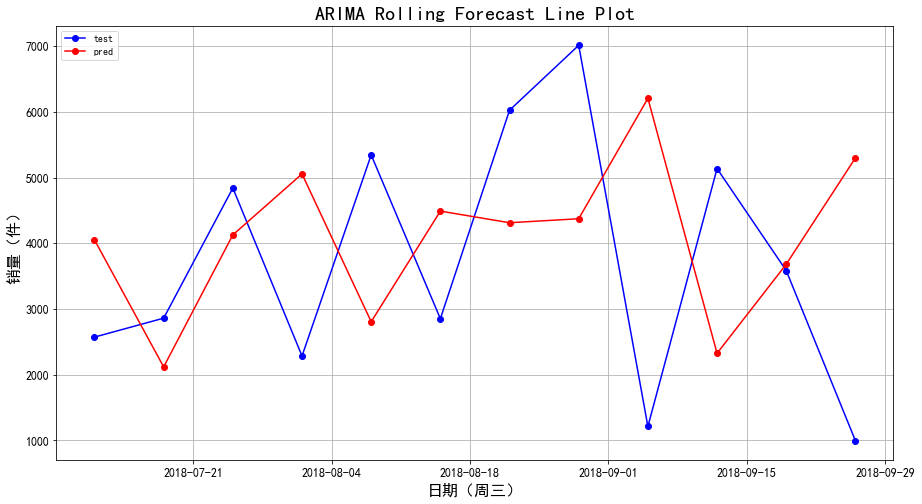

In [47]:
fig, ax = plt.subplots()
ax.plot(test_wed.index, test, 'bo-', label='test')
ax.plot(test_wed.index, preds, 'ro-', label='pred')
ax.set_xlabel('日期（周三）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('ARIMA Rolling Forecast Line Plot', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig.savefig("../figs/ARIMA预测图.png")
plt.show()

### 3.4 SARIMAX

In [27]:
train, test = train_wed.order_num.values, test_wed.order_num.values

In [28]:
# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 1) for x in pdq]

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = SARIMAX(train,
                              order = param,
                              seasonal_order = param_seasonal,
                              enforce_stationarity=True,
                              enforce_invertibility=True)
            res = tmp_mdl.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [29]:
history = list(train)
preds = list()
for i in range(len(test)):
    model = SARIMAX(train, order=(2, 1, 1), seasonal_order=(0, 2, 2, 1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    preds.append(yhat)
    obs = test[i]
    history.append(obs)
    print("expected = %f predicted = %f" % (obs, yhat))
error = sqrt(mean_squared_error(test, preds))
print("Test RMSE: %.3f" % error)

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 2572.000000 predicted = 5180.312861


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 2860.000000 predicted = 5180.312861


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 4840.000000 predicted = 5180.312861


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 2284.000000 predicted = 5180.312861


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 5344.000000 predicted = 5180.312861


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 2852.000000 predicted = 5180.312861


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 6024.000000 predicted = 5180.312861


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 7012.000000 predicted = 5180.312861


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 1212.000000 predicted = 5180.312861


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 5136.000000 predicted = 5180.312861


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 3584.000000 predicted = 5180.312861
expected = 996.000000 predicted = 5180.312861
Test RMSE: 2345.429


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


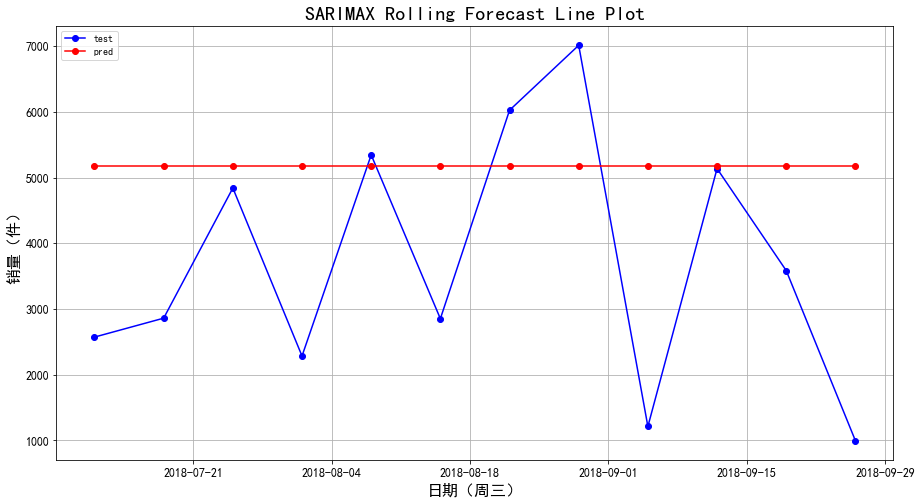

In [30]:
fig, ax = plt.subplots()
ax.plot(test_wed.index, test, 'bo-', label='test')
ax.plot(test_wed.index, preds, 'ro-', label='pred')
ax.set_xlabel('日期（周三）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('SARIMAX Rolling Forecast Line Plot', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig.savefig("../figs/SARIMAX预测图.png")
plt.show()